In [1]:
from eda_imports import *

import pysam
from tqdm import tqdm

import kleat.misc.settings as S
import kleat.misc.utils as U
from kleat.misc.apautils import calc_genome_offset
from kleat.evidence import bridge

from kleat.visaln import visaln

seaborn not found


In [ ]:
ls ../../kleat/benchmark_transcriptome/UHRC1/

In [7]:
# DATA_DIR='/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-TCGA-analysis-scripts/benchmark-kleat.bk/UHR/C1/tasrkleat-results'
DATA_DIR='../../kleat/'
c2g_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/UHRC1/c2g.bam'))
r2c_bam = pysam.AlignmentFile(os.path.join(DATA_DIR, './benchmark_transcriptome/UHRC1/r2c_sorted.bam'))

In [8]:
contig_name = 'E1.L.9227'
reference_name = 'chrM'
predicted_clvs = sorted([16565])

In [9]:
for contig in c2g_bam:
    if contig.query_name == contig_name and contig.reference_name == reference_name:
#         if contig.reference_name == 'chr16' and contig.is_reverse:
            print(contig.cigarstring)
            break

410M1D387M188S


In [10]:
contig.reference_name

'chrM'

In [11]:
print(contig.query_name, contig.is_reverse, contig.reference_start)
print(contig.cigarstring)

E1.L.9227 False 15773
410M1D387M188S


In [12]:
reads = r2c_bam.fetch(contig.query_name)
bdg_read_info = []
for rd in reads:
    if bridge.is_a_bridge_read(rd):
        if contig.is_reverse:
            contig_len = contig.infer_query_length(always=True)
            bdg_read_info.append([
                contig_len - rd.reference_end,
                contig_len - rd.reference_start,
                not rd.is_reverse,
                f'rev({rd.cigarstring})',
                tuple(reversed(rd.cigartuples))
            ])
        else:
            contig_len = contig.infer_query_length(always=True)            
            bdg_read_info.append([                
                rd.reference_start,
                rd.reference_end,
                rd.is_reverse,
                f'{rd.cigarstring}',
                rd.cigartuples
            ])

In [13]:
df_bdg_read = pd.DataFrame(bdg_read_info, columns=['reference_start', 'reference_end', 'is_reverse', 'cigarstring', 'cigartuples'])
df_bdg_read = df_bdg_read.sort_values('reference_start').reset_index(drop=True)

In [14]:
df_bdg_read.shape

(35, 5)

In [15]:
df_bdg_read

,reference_start,reference_end,is_reverse,cigarstring,cigartuples
0,200,266,True,66M8S,"[(0, 66), (4, 8)]"
1,248,317,True,69M4S,"[(0, 69), (4, 4)]"
2,257,322,True,65M9S,"[(0, 65), (4, 9)]"
3,293,363,True,70M5S,"[(0, 70), (4, 5)]"
4,341,411,True,70M5S,"[(0, 70), (4, 5)]"
5,341,411,True,70M5S,"[(0, 70), (4, 5)]"
6,343,416,True,73M2S,"[(0, 73), (4, 2)]"
7,343,416,True,73M2S,"[(0, 73), (4, 2)]"
8,343,416,True,73M2S,"[(0, 73), (4, 2)]"
9,343,416,True,73M2S,"[(0, 73), (4, 2)]"


In [16]:
contig_sr = pd.Series(
    [contig.reference_start, contig.reference_end, contig.cigarstring, contig.cigartuples], 
    index=['reference_start', 'reference_end', 'cigarstring', 'cigartuples']
)

In [17]:
contig_sr.to_frame().T

,reference_start,reference_end,cigarstring,cigartuples
0,15773,16571,410M1D387M188S,"[(0, 410), (2, 1), (0, 387), (4, 188)]"


In [18]:
num_skips = visaln.calc_num_skips(contig)
# TODO: turn this into accepting predicted_clvs
df_xlims = visaln.calc_xlim_pairs(contig, predicted_clvs[0])

In [19]:
df_xlims

,xmin,xmax,span,cover_prd_clv
0,15771,16760,989,True


15771 - 16760, covering clv True


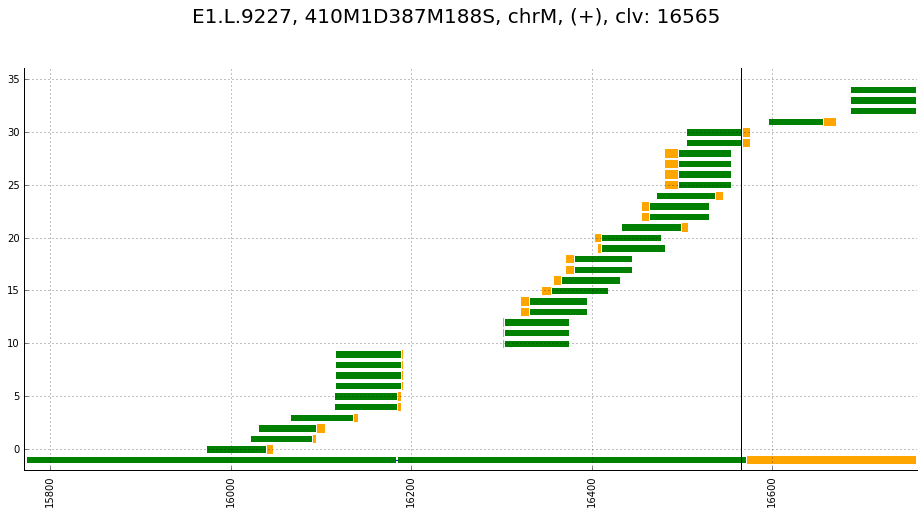

In [23]:
num_subplots = num_skips + 1
fig_height = (df_bdg_read.shape[0] + 1) * 0.2

fig, axes = plt.subplots(
    1, num_skips + 1, figsize=(16, fig_height), sharey=True, 
    gridspec_kw = {
        'width_ratios':df_xlims.span, 
        'hspace': 0.5
    }
)

if num_subplots == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for ki, row in df_xlims.iterrows():
    ax = axes[ki]
    height = 0.6
    for k, read in df_bdg_read.iterrows():
        cx = visaln.get_abs_start(read)
        cx = visaln.convert_contig2genome_coord(cx, contig)
        cy = k
        visaln.draw_alignment(ax, cx, cy, read)

    cx = visaln.get_abs_start(contig)
    visaln.draw_alignment(ax, cx, cy=-1, aln=contig)

    ylim = [-2, df_bdg_read.shape[0] + 1]

    for _clv in predicted_clvs:
        ax.plot([_clv, _clv], ylim, color='black')
    ax.set_ylim(ylim)
    print(f'{row.xmin} - {row.xmax}, covering clv {row.xmin <= _clv <= row.xmax}')
    ax.set_xlim(row.xmin, row.xmax)
    
    for tick in ax.get_xticklabels(): tick.set_rotation(90)    
    
    if ki > 0:
        ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if ki == 0:
        ax.tick_params(top=False, right=False)
    if ki > 0:
        ax.tick_params(top=False, right=False, left=False)
        
    ax.yaxis.grid()
    ax.xaxis.grid()
    
strand = '-' if contig.is_reverse else '+'
fig.suptitle(f'{contig.query_name}, {contig.cigarstring}, {contig.reference_name}, ({strand}), clv: {_clv}', fontsize=20, y =1.02)

# xlim = ax.get_xlim()
# ax.set_xlim(xlim[0] -50, xlim[1] + 50)

xlim = ax.get_xlim()
# ax.set_xlim(xlim[0] + 2640, xlim[1] - 190)

26256756 - 26257810, covering clv False
26321323 - 26321797, covering clv False
26332429 - 26332981, covering clv False
26349805 - 26350308, covering clv False
26350511 - 26351026, covering clv False
26357599 - 26360496, covering clv True


(26360239.0, 26360306.0)

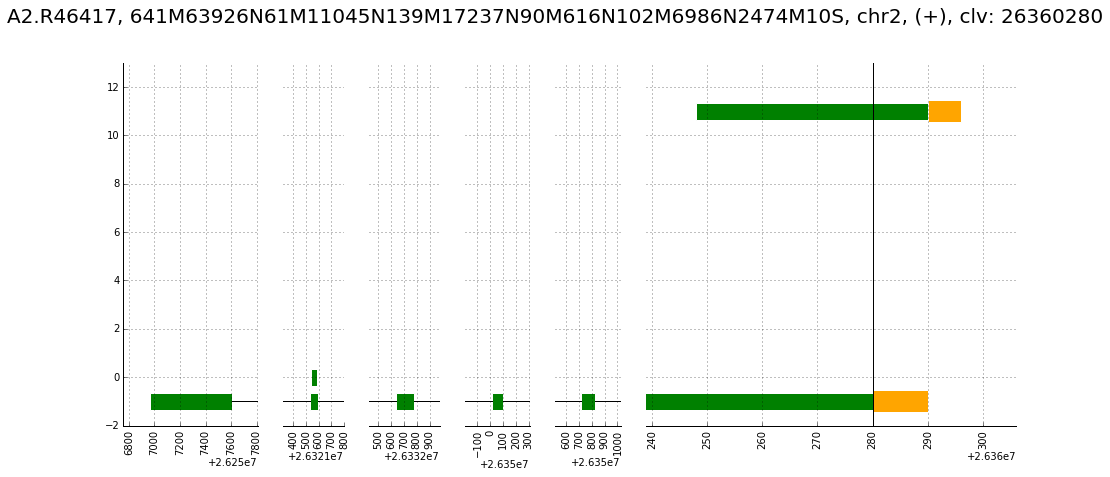

In [75]:
num_subplots = num_skips + 1
fig_height = (df_bdg_read.shape[0] + 1) * 0.5

fig, axes = plt.subplots(
    1, num_skips + 1, figsize=(16, fig_height), sharey=True, 
    gridspec_kw = {
        'width_ratios':df_xlims.span, 
        'hspace': 0.5
    }
)

if num_subplots == 1:
    axes = [axes]
else:
    axes = axes.ravel()

for ki, row in df_xlims.iterrows():
    ax = axes[ki]
    height = 0.6
    for k, read in df_bdg_read.iterrows():
        cx = visaln.get_abs_start(read)
        cx = visaln.convert_contig2genome_coord(cx, contig)
        cy = k
        visaln.draw_alignment(ax, cx, cy, read)

    cx = visaln.get_abs_start(contig)
    visaln.draw_alignment(ax, cx, cy=-1, aln=contig)

    ylim = [-2, df_bdg_read.shape[0] + 1]

    for _clv in predicted_clvs:
        ax.plot([_clv, _clv], ylim, color='black')
    ax.set_ylim(ylim)
    print(f'{row.xmin} - {row.xmax}, covering clv {row.xmin <= _clv <= row.xmax}')
    ax.set_xlim(row.xmin, row.xmax)
    
    for tick in ax.get_xticklabels(): tick.set_rotation(90)    
    
    if ki > 0:
        ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if ki == 0:
        ax.tick_params(top=False, right=False)
    if ki > 0:
        ax.tick_params(top=False, right=False, left=False)
        
    ax.yaxis.grid()
    ax.xaxis.grid()
    
strand = '-' if contig.is_reverse else '+'
fig.suptitle(f'{contig.query_name}, {contig.cigarstring}, {contig.reference_name}, ({strand}), clv: {_clv}', fontsize=20, y =1.02)

# xlim = ax.get_xlim()
# ax.set_xlim(xlim[0] -50, xlim[1] + 50)

# xlim = ax.get_xlim()
ax.set_xlim(xlim[0] + 2640, xlim[1] - 190)

In [2]:
c2g_bam_file = '/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-PAS-dynamics-analysis/../tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185669.176b2422-3599-41c5-be62-ae6e28d60b90.121205_UNC14-SN744_0276_AC19W1ACXX_6_CAGATC.tar.gz/tasrkleat-results/align_contigs2genome/cba.sorted.bam'
r2c_bam_file = '/projects/btl/zxue/tasrkleat-TCGA-results/tasrkleat-PAS-dynamics-analysis/../tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185669.176b2422-3599-41c5-be62-ae6e28d60b90.121205_UNC14-SN744_0276_AC19W1ACXX_6_CAGATC.tar.gz/tasrkleat-results/align_reads2contigs/cba.sorted.bam'

In [3]:
c2g_bam = pysam.AlignmentFile(c2g_bam_file)
r2c_bam = pysam.AlignmentFile(r2c_bam_file)

In [4]:
contig_name = 'A0.R247312'
reference_name = 'chr10'
predicted_clvs = sorted([89731686])